In [11]:
from keras.datasets import fashion_mnist
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D 
from keras.layers import UpSampling2D, Dropout, Activation, Flatten 
from keras.layers import LeakyReLU, LSTM, Conv1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

We see that our training data contains 6,000 images of dimension 28x28, while our testing data contains 10,000 images of dimension 28x28. It is also in unit8 format (which we will change).


In [201]:
print('Train:', x_train.shape, y_train.shape)

print('Test:', x_test.shape, y_test.shape)

print(x_train.dtype)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)
uint8


In [0]:
#rescale image pixels to values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [0]:
# FOR 2.2
#convert images to three channels
train_X = np.stack([x_train] *3, axis = -1)
test_X = np.stack([x_test] *3, axis = -1)
train_X = train_X.reshape(-1, 28,28,3)
test_X = test_X.reshape (-1,28,28,3)

#resize the images to 48 x 48 for VGG16
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])


#converting labels to one hot encoded format
train_Y_one_hot = np_utils.to_categorical(y_train)
test_Y_one_hot = np_utils.to_categorical(y_test)

#split train data as train and validation data
train_X,valid_X,train_Label,valid_Label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13)

In [0]:
# FOR 1
#reshape data from 6,000 x 28 x 28 to single image dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

**1 Autoencoder**

In [0]:
input_img = Input(shape=(28, 28, 1))  

#compress image for encoding:

# 28 x 28 x 16 matrix
x = Conv2D(16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
# 14 x 14 x 16 matrix
x = MaxPooling2D((2, 2), padding='same')(x)
# 14 x 14 x 8 matrix
x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
# 7 x 7 x 8 matrix
x = MaxPooling2D((2, 2), padding='same')(x)
# 7 x 7 x 8 matrix
x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)

#image is encoded as 4 x 4 x 8 matrix
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 4 x 4 x 8 matrix
x = Conv2D(8, kernel_size =  (3, 3), activation='relu', padding='same')(encoded)
# 8 x 8 x 8 matrix
x = UpSampling2D((2, 2))(x)
# 8 x 8 x 8 matrix
x = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(x)
# 16 x 16 x 8 matrix
x = UpSampling2D((2, 2))(x)
# 14 x 14 x 16 matrix
x = Conv2D(16, kernel_size = (3, 3), activation='relu')(x)
# 28 x 28 x 16 matrix
x = UpSampling2D((2, 2))(x)

#image is decoded as 28 x 28 x 1 matrix
decoded = Conv2D(1, kernel_size = (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#we use sigmoid activation and binary cross-entropy loss because pixels have 
#values between 0 and 1

Over 10 epochs, the validation loss on the autoencoder improved from about 0.328 to about 0.295.

In [11]:
autoencoder.fit(x_train, x_train,
                epochs = 10,
                batch_size = 64,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 248us/step - loss: 0.3457 - val_loss: 0.3282
Epoch 2/10
60000/60000 [==============================] - 12s 208us/step - loss: 0.3086 - val_loss: 0.3040
Epoch 3/10
60000/60000 [==============================] - 13s 216us/step - loss: 0.3015 - val_loss: 0.3043
Epoch 4/10
60000/60000 [==============================] - 12s 206us/step - loss: 0.2980 - val_loss: 0.2996
Epoch 5/10
60000/60000 [==============================] - 12s 208us/step - loss: 0.2956 - val_loss: 0.3013
Epoch 6/10
60000/60000 [==============================] - 12s 208us/step - loss: 0.2937 - val_loss: 0.2968
Epoch 7/10
60000/60000 [==============================] - 12s 208us/step - loss: 0.2923 - val_loss: 0.2917
Epoch 8/10
60000/60000 [==============================] - 12s 207us/step - loss: 0.2917 - val_loss: 0.2936
Epoch 9/10
60000/60000 [==============================] - 13s 210us/step - loss: 0.2907 - val_

The reconstructed images below show that the autoencoder was able to reproduce the general shapes of the clothin items, but could not reproduce nuances such as patterns on the shirts.

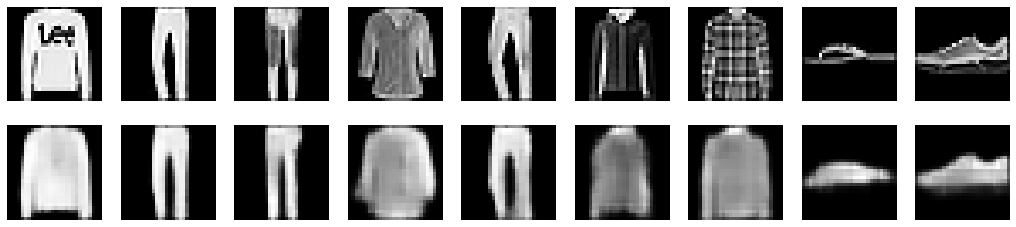

In [12]:
# Reconstructed images
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # autoencoder reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**2 Image Classification **

The data has 10 classes between 0 and 9, which describe the type of clothing each image represents.

In [13]:
classes = np.unique(y_train)
print(classes)

[0 1 2 3 4 5 6 7 8 9]


In [0]:
#convert classes to 10 dimension matrices (one-hot encoding)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [0]:
train_x,valid_x,train_label,valid_label = train_test_split(x_train, y_train, test_size=0.2, random_state=13)

**2.1 Deep CNN**

In [0]:
fashion_model = Sequential()

'''
I will use leaky ReLU because I read in some article somewhere that leaky 
ReLU corrects the dying ReLU problem over large gradients.

I have chosen the kernels to be size 3x3 and the strides to be 1x1 to 
gradually sub-sample the inputs. I also chose a pool size of 2x2 to 
downsample gradually.

I have chosen valid padding because the most important information in the image
will likely be towards the center, not on the perimeter where valid padding will
lose some information. 

For network depth, I chose two layers because I didn't want the model to get
too complicated.

'''
fashion_model.add(Conv2D(32, kernel_size = (3, 3),
                         activation='linear',
                         input_shape=(28,28,1),
                         strides=(1, 1),
                         padding='valid'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='valid'))
fashion_model.add(Dropout(0.25))


fashion_model.add(Conv2D(64, kernel_size = (3, 3), 
                         activation='linear',
                         strides=(1, 1),
                         padding='valid'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
fashion_model.add(Dropout(0.25)) 


# fully connected layer
fashion_model.add(Flatten())
fashion_model.add(Dense(64, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.5))
fashion_model.add(Dropout(0.5))                 
fashion_model.add(Dense(len(classes), activation='softmax'))

The summary of the model shows that we have a total of 121,930 parameters over 13 layers.

In [17]:
fashion_model.compile(loss= 'categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [18]:
fashion_train = fashion_model.fit(train_x, train_label, batch_size = 64,
                                  epochs = 10,verbose=1,validation_data=(valid_x, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 11s 221us/step - loss: 0.6613 - acc: 0.7621 - val_loss: 0.4211 - val_acc: 0.8482
Epoch 2/10
48000/48000 [==============================] - 10s 200us/step - loss: 0.4401 - acc: 0.8433 - val_loss: 0.3538 - val_acc: 0.8735
Epoch 3/10
48000/48000 [==============================] - 10s 200us/step - loss: 0.3921 - acc: 0.8603 - val_loss: 0.3229 - val_acc: 0.8872
Epoch 4/10
48000/48000 [==============================] - 10s 201us/step - loss: 0.3564 - acc: 0.8746 - val_loss: 0.3094 - val_acc: 0.8863
Epoch 5/10
48000/48000 [==============================] - 10s 200us/step - loss: 0.3451 - acc: 0.8762 - val_loss: 0.2968 - val_acc: 0.8936
Epoch 6/10
48000/48000 [==============================] - 10s 199us/step - loss: 0.3278 - acc: 0.8835 - val_loss: 0.2978 - val_acc: 0.8886
Epoch 7/10
48000/48000 [==============================] - 10s 199us/step - loss: 0.3178 - acc: 0.8860 - val_loss: 0.

In [0]:
test_eval = fashion_model.evaluate(x_test, y_test, verbose=0)

Over 10 epochs, the model improved from a validation loss and accuracy of about 0.421 and 0.848, to about 0.293 and 0.892, respectively. The model also performed better in terms of accuracy on the validation set than the training set, suggesting the model was not overfitting.

**2.2 Transfer Learning**

The data has already been set up into three channels for VGG16.

The convolutional base has a total of 14,714,688 parameters over 19 layers.

In [204]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
conv_base.trainable = False
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [205]:
#extract features from convolutional base
train_features = conv_base.predict(np.array(train_X), batch_size=32, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=32, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=32, verbose=1)

12000/12000 [==============================] - 9s 786us/step


In [0]:
#flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [0]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(len(classes), activation='softmax'))

Our model with only three layers has a total of 267,786 parameters.

In [208]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                5130      
Total params: 267,786
Trainable params: 267,786
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss="categorical_crossentropy", optimizer = 'Adam',metrics=["accuracy"])

In [210]:
#train model with convolutional base features
trans_model = model.fit(
    train_features_flat,
    train_Label,
    epochs=10,
    validation_data=(val_features_flat, valid_Label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 10s 206us/step - loss: 1.8395 - acc: 0.3279 - val_loss: 1.7393 - val_acc: 0.3663
Epoch 2/10
48000/48000 [==============================] - 9s 184us/step - loss: 1.7025 - acc: 0.3784 - val_loss: 1.6796 - val_acc: 0.3915
Epoch 3/10
48000/48000 [==============================] - 9s 185us/step - loss: 1.6627 - acc: 0.3882 - val_loss: 1.6479 - val_acc: 0.3987
Epoch 4/10
48000/48000 [==============================] - 9s 185us/step - loss: 1.6390 - acc: 0.3962 - val_loss: 1.6304 - val_acc: 0.4035
Epoch 5/10
48000/48000 [==============================] - 9s 184us/step - loss: 1.6202 - acc: 0.4021 - val_loss: 1.6420 - val_acc: 0.4016
Epoch 6/10
48000/48000 [==============================] - 9s 186us/step - loss: 1.6060 - acc: 0.4071 - val_loss: 1.6336 - val_acc: 0.3953
Epoch 7/10
48000/48000 [==============================] - 9s 186us/step - loss: 1.5945 - acc: 0.4121 - val_loss: 1.6054 -

The transfer learning model improved over 10 epochs from a validation loss and accuracy of about 1.739 and 0.366 to about 1.596 and 0.413, respectively. The training losses and accuracies are similarly poor. Overall, this model performed much worse than the deep CNN in the previous part. 




**3 Text Classification**

In [3]:
import pandas as pd
import nltk
import collections
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalMaxPooling1D, LSTM
from keras.callbacks import TensorBoard
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from keras.layers import LSTM, Conv1D, GlobalMaxPooling1D
import regex
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import sequence

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tianjingrong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tianjingrong/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tianjingrong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import re
tweets = pd.read_csv('tweets_with_labels.csv', sep = '\t')

# clean tweets
stopWords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_tweets(tweet):
    tweet = re.sub("@mention", "",tweet)
    tweet = re.sub("{link}", "",tweet)
    tweet = re.sub("[^A-Za-z]"," ",tweet)
    tweet = re.sub(r'\bRT\b', '', tweet)
    tweet = re.sub("\s+"," ",tweet)
    tokens = word_tokenize(tweet)
    words = [word for word in tokens if word not in stopWords]
    words = [stemmer.stem(w).strip("'") for w in words]
    words = [lemmatizer.lemmatize(w, pos="a") for w in words]
    words = [word for word in words if len(word)!=1]
    final_tweet = ' '.join(words)
    return final_tweet

new_tweet = [preprocess_tweets(x) for x in list(tweets.tweet)]
tweets['new_tweets'] = new_tweet

In [7]:
token = [word_tokenize(x) for x in list(tweets.new_tweets)]

# clean out empty new_tweets by removing them
remove_lst=[]
for w in token:
    remove_lst.append(len(w))
bad_idx = [n for n,x in enumerate(remove_lst) if x == 0]
tweets_updated = tweets.drop(bad_idx)

# preprocess finished and define X and y for train test split

X = [word_tokenize(x) for x in list(tweets_updated['new_tweets'])]

# label y for any k1 to k15 not equal to 0
label = tweets_updated.loc[:,'k1':'k15']
label[tweets_updated != 0] = 1
y = label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [8]:
print('X_train shape: ', len(X_train))
print('X_test shape: ', len(X_test))
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  54551
X_test shape:  23379
y_train shape:  (54551, 15)
y_test shape:  (23379, 15)


In [9]:
# padding token sequense to max length of 40
X_train_padded = sequence.pad_sequences(X_train, maxlen=40, padding="post", truncating="post", value='_pad_',dtype=object)
X_test_padded = sequence.pad_sequences(X_test, maxlen=40, padding="post", truncating="post", value='_pad_',dtype=object)

train_corpus = list(tweets_updated.new_tweets)
train_cor_tk = [word_tokenize(x) for x in train_corpus]
corpus_padded = sequence.pad_sequences(train_cor_tk, maxlen=40,padding="post", truncating="post", value='_pad_',dtype=object)

corpus_padded = corpus_padded.tolist()
X_train_padded = X_train_padded.tolist()
X_test_padded = X_test_padded.tolist()

In [12]:
#  train word2vec and vectorizing training set and test set 
w2v_model = Word2Vec(corpus_padded, min_count=1, size = 20, workers=1, window=3)

# vector with size train/test, maxlen = 40 
X_train_vec = np.empty([len(X_train), 40, 20])
X_test_vec = np.empty([len(X_test), 40, 20])

idx_train = 0
for w in X_train_padded:
    X_train_vec[idx_train, :, :] = w2v_model[w]
    idx_train += 1

idx_test = 0
for w in X_test_padded:
    X_test_vec[idx_test,:,:] = w2v_model[w]
    idx_test += 1

print('X_train_vec shape: ', X_train_vec.shape)
print('X_test_vec shape: ', X_test_vec.shape)

/Users/tianjingrong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/tianjingrong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


X_train_vec shape:  (54551, 40, 20)
X_test_vec shape:  (23379, 40, 20)


In [13]:
#  Build LSTM model
model_rnn = Sequential()
model_rnn.add(LSTM(128, input_shape = (40, 20)))
model_rnn.add(Dense(128, activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(64, activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(15, activation ='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model_rnn.fit(X_train_vec, y_train,
                        epochs=10, batch_size=500,
                        validation_data=(X_test_vec, y_test))

Train on 54551 samples, validate on 23379 samples
Epoch 1/10
54551/54551 [==============================] - 49s 902us/step - loss: 0.3788 - accuracy: 0.8480 - val_loss: 0.3219 - val_accuracy: 0.8748
Epoch 2/10
54551/54551 [==============================] - 46s 847us/step - loss: 0.3306 - accuracy: 0.8731 - val_loss: 0.3210 - val_accuracy: 0.8748
Epoch 3/10
54551/54551 [==============================] - 50s 919us/step - loss: 0.3272 - accuracy: 0.8739 - val_loss: 0.3209 - val_accuracy: 0.8748
Epoch 4/10
54551/54551 [==============================] - 44s 809us/step - loss: 0.3228 - accuracy: 0.8744 - val_loss: 0.3073 - val_accuracy: 0.8748
Epoch 5/10
54551/54551 [==============================] - 45s 822us/step - loss: 0.2926 - accuracy: 0.8853 - val_loss: 0.2498 - val_accuracy: 0.9018
Epoch 6/10
54551/54551 [==============================] - 43s 793us/step - loss: 0.2204 - accuracy: 0.9181 - val_loss: 0.1843 - val_accuracy: 0.9308
Epoch 7/10
54551/54551 [==============================] 

In [19]:
#  evaluate the model
score = model_rnn.evaluate(X_test_vec, y_test, batch_size=64, verbose = 0)

In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Train loss: ', history.history['loss'][9]) 
print('Train accuracy: ', history.history['accuracy'][9])

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Train loss:  0.1674645992722844
Train accuracy:  0.94115615
Test loss:  0.1558494813049659
Test accuracy:  0.9439318776130676


### 3.2 1D CNN

In [26]:
model_cnn = Sequential()
model_cnn.add(Conv1D(128, 3, activation='relu', padding = 'valid', strides=1, input_shape=(40,20)))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(15, activation ='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_vec, y_train, epochs=10, batch_size=128,
                        validation_data=(X_test_vec, y_test))

Train on 54551 samples, validate on 23379 samples
Epoch 1/10
54551/54551 [==============================] - 10s 175us/step - loss: 0.2326 - accuracy: 0.9147 - val_loss: 0.1707 - val_accuracy: 0.9378
Epoch 2/10
54551/54551 [==============================] - 6s 119us/step - loss: 0.1769 - accuracy: 0.9381 - val_loss: 0.1594 - val_accuracy: 0.9424
Epoch 3/10
54551/54551 [==============================] - 6s 104us/step - loss: 0.1686 - accuracy: 0.9409 - val_loss: 0.1551 - val_accuracy: 0.9444
Epoch 4/10
54551/54551 [==============================] - 6s 108us/step - loss: 0.1643 - accuracy: 0.9423 - val_loss: 0.1543 - val_accuracy: 0.9448
Epoch 5/10
54551/54551 [==============================] - 5s 94us/step - loss: 0.1613 - accuracy: 0.9431 - val_loss: 0.1519 - val_accuracy: 0.9452
Epoch 6/10
54551/54551 [==============================] - 7s 123us/step - loss: 0.1589 - accuracy: 0.9437 - val_loss: 0.1503 - val_accuracy: 0.9456
Epoch 7/10
54551/54551 [==============================] - 7s 1

The RNN model performed well in terms of accuracy on the validation set. This is not surprising because the data was highly skewed towards one label (benign). The confusion matrix below shows that we have:

false positive rate = 0.007

true positive rate = 0.993

true negative rate = 0.813

false negative rate = 0.187

The model still struggled with labeling malicious urls as benign.


In [27]:
# evaluate the model
score_cnn = model_cnn.evaluate(X_test_vec, y_test, batch_size=64, verbose = 0)

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Train loss: ', history_cnn.history['loss'][9]) 
print('Train accuracy: ', history_cnn.history['accuracy'][9])

print('Test loss: ', score_cnn[0])
print('Test accuracy: ', score_cnn[1])

Train loss:  0.15258462122702948
Train accuracy:  0.9457302
Test loss:  0.14716374050755565
Test accuracy:  0.9469528198242188


### 3.3 RNN CNN Comparison

Text(0.5, 1.0, 'Text Classification Accuracy RNN CNN Comparison')

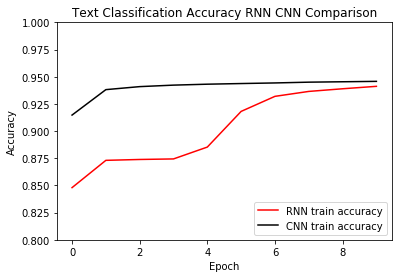

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='RNN train accuracy', color = 'r')
plt.plot(history_cnn.history['accuracy'], label = 'CNN train accuracy', color = 'k')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Text Classification Accuracy RNN CNN Comparison')

Text(0.5, 1.0, 'Text Classification Loss RNN CNN Comparison')

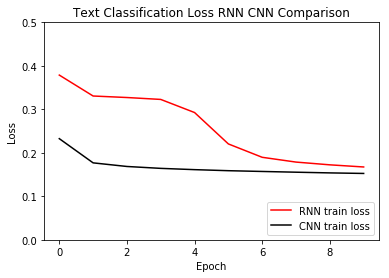

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='RNN train loss', color = 'r')
plt.plot(history_cnn.history['loss'], label = 'CNN train loss', color = 'k')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
plt.title('Text Classification Loss RNN CNN Comparison')

In [35]:
import cv2

LSTM model converges much slower than CNN model. The ROC curve of the 15 labels indicates that CNN outperforms LSTM in most cases.